In [1]:
from kaveh.behavioral.oculomotor.session import session
from kaveh.toolbox import find_file
from neo.io import Spike2IO
from matplotlib import pyplot as plt
import numpy as np
import quantities as pq
import csv
import os
import fnmatch
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
from matplotlib import style
style.use('bmh')
COLOR = 'gray'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
def bin_error_dirs(error_dirs):
    '''
    Bin error directions: Bins start from 157.5 and increaments counter-clockwise every 45 degrees => 8 bins, 0 to 7
    '''
    bins = np.arange(-180 + 22.5, 180, 45)
    bin_ind = np.digitize(error_dirs , bins, right=True)
    bin_ind[bin_ind == 8] = 0
    return bin_ind


import quantities as pq

def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
#     cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []
    bin_cs_prob = []
    bin_size = []
    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_prob = cs_count*1.0/bin_times.size
            bin_cs_prob.append(cs_prob)
            bin_cs_counts.append(cs_count)
            bin_size.append(bin_times.size)
        else:
            bin_cs_counts.append(0)
            bin_cs_prob.append(0)
            bin_size.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
    bin_cs_prob = np.array(bin_cs_prob)
    bin_size = np.array(bin_size)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return (bin_cs_counts, bin_cs_prob, bin_size)

In [4]:
with open('../data/david_neurs.csv', 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader))
neuron_names = np.array([fn[0].split('\t')[0].split('\t')[0] for fn in csv_content if fn[0][-1][-1] == '1'])

file_names = []
for nn in neuron_names:
    matches = []
    for root, dirnames, filenames in os.walk('../data/david_neurons/' + nn):
        for filename in fnmatch.filter(filenames, '*.smr.pkl'):
            matches.append(os.path.join(root, filename))
    if matches:
        for ff in matches:
            if os.path.exists(ff+'.GMM.CS.csv'):
                file_names.append(os.path.basename(ff)[0:-4])

# List of files with adapt/Adapt in their filenames 
adapt_filenames = [fb for fb in file_names if any(s in fb for s in ('adapt','Adapt') if 'PreAdapt' not in fb and 'Preadapt' not in fb)]
               

In [6]:
adapt_filenames[26]

'B091608_1218_Adapt.smr'

In [6]:
# dont include: 0,1,2,27
# 5 is fine but half the session target jump is 1 degrees => not detected
# 6,7,8,9,10,13,15, 19,26,27,29, 36 fine but doesn't seem to be in cs_on/off axis
# 30: look at the detected complex spikes
f_name = adapt_filenames[3]
f_name_smr = find_file(os.path.basename(f_name), '../data/david_neurons')
f_name_session = find_file(os.path.basename(f_name)+'.pkl.session.pkl', '../data/david_neurons')
f_name_csv = find_file(os.path.basename(f_name)+'.pkl.GMM.CS.csv', '../data/david_neurons')

print(f_name)
with open(f_name_session, 'rb') as input:
    try:
        mysess = pickle.load(input, encoding='latin1')
    except TypeError:
        mysess = pickle.load(input)

iss_range = pq.quantity.Quantity(0.025, 's')
iss_targets = []
iss_saccades = []
saccades_with_no_iss_target = []
for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
#     iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
#                                                              mysess.target_onset_times > son - iss_range), 
#                                               np.logical_and(mysess.target_offset_times < soff + iss_range, 
#                                                              mysess.target_offset_times > soff - iss_range)))[0])
    iss_targets.append(np.where(np.logical_and(mysess.target_onset_times > son - iss_range , mysess.target_offset_times < soff + iss_range))[0])
    if iss_targets[-1].size != 0:
        iss_saccades.append(i)
    if iss_targets[-1].size == 0:
        saccades_with_no_iss_target.append(i)

iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), iss_targets)


saccade_rt = []
saccade_rt_target_offset_times = []
saccade_rt_target_offset_indices = []
for i, toff in enumerate(mysess.target_offset_times[non_iss_target_jumps]):

    delay_to_next_saccade = mysess.saccade_onset_times[np.argmax(mysess.saccade_onset_times > toff)] - toff
    delay_to_next_target_jump = mysess.target_onset_times[non_iss_target_jumps][np.argmax(mysess.target_onset_times[non_iss_target_jumps] > toff)] - toff
    # Only consider reaction times that are less than 600ms and are occurring before the next target jump
    if delay_to_next_saccade <= delay_to_next_target_jump and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0:
        saccade_rt.append(delay_to_next_saccade)
        saccade_rt_target_offset_times.append(toff)
        saccade_rt_target_offset_indices.append(i)

saccade_rt = np.squeeze(np.array(saccade_rt))
saccade_rt_target_offset_times = np.squeeze(np.array(saccade_rt_target_offset_times))
saccade_rt_target_offset_indices = np.squeeze(np.array(saccade_rt_target_offset_indices))


K32_1oblRBWLBWadapt.smr


<IPython.core.display.Javascript object>


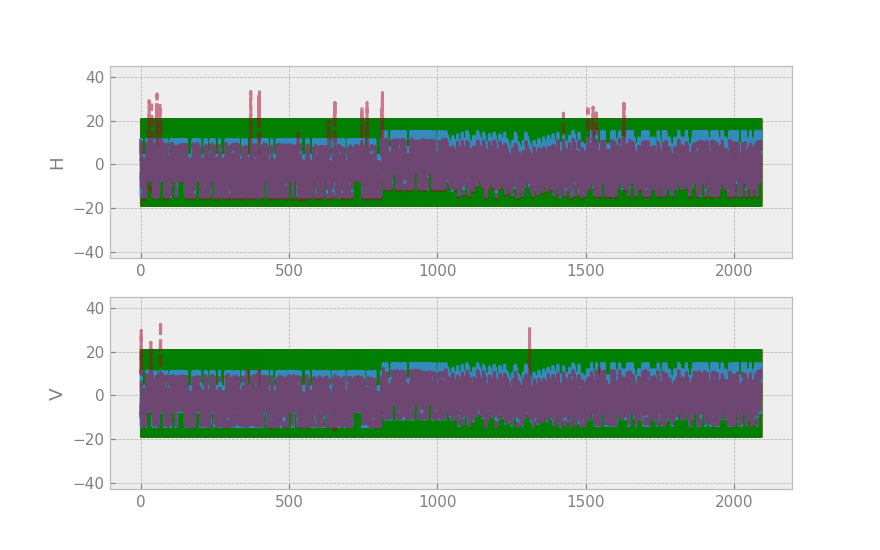

In [7]:
import gc
gc.collect()

plt.figure(figsize=(8,5))
ax1 = plt.subplot(211)
plt.plot(mysess.t_HT, mysess.HT)
plt.plot(mysess.t_HE, mysess.HE, '--', alpha = 0.5)
plt.ylabel('H')
plt.eventplot(mysess.target_onset_times[non_iss_target_jumps], linelengths=40, colors='r', alpha = 0.5)
plt.eventplot(mysess.target_onset_times[iss_targets], linelengths=40, colors='g', alpha = 0.5)
ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.plot(mysess.t_VT, mysess.VT)
plt.plot(mysess.t_VE, mysess.VE, '--', alpha = 0.5)
plt.ylabel('V')
plt.eventplot(mysess.target_onset_times[non_iss_target_jumps], linelengths=40, colors='r', alpha = 0.5)
plt.eventplot(mysess.target_onset_times[iss_targets], linelengths=40, colors='g', alpha = 0.5)
# plt.eventplot(mysess.saccade_offset_times, linelengths=40, colors='k', alpha = 0.5)
# plt.eventplot(mysess.saccade_onset_times, linelengths=40, colors='b', alpha = 0.5)

In [8]:
toff_V = np.squeeze(mysess.VT[mysess.target_offsets])
ton_V = np.squeeze(mysess.VT[mysess.target_onsets])
jump_vec_V = toff_V - ton_V

toff_H = np.squeeze(mysess.HT[mysess.target_offsets])
ton_H = np.squeeze(mysess.HT[mysess.target_onsets])
jump_vec_H = toff_H - ton_H


jump_dir = np.arctan2(jump_vec_V, jump_vec_H)*180/np.pi

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2).fit(jump_dir.reshape(-1,1))


In [9]:
mysess.HT[mysess.target_offsets].shape

(3338, 1)

In [10]:
jump_dir.shape

(3338,)

In [11]:
# get cs_prob for each cluster
from neo.io import Spike2IO

neo_reader = Spike2IO(filename=f_name_smr)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]
events = seg.events

 # Load voltage
t_signal = seg.analogsignals[-1].times
signal_fs = seg.analogsignals[-1].sampling_rate

with open(f_name_csv, 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader), dtype=np.int64)

cs_indices = np.squeeze(csv_content[np.where(csv_content[:,1] == 1), 0])
cs_times = t_signal[cs_indices]

In [12]:
cs_range = pq.quantity.Quantity(0.200, 's')
cs_prob = [0,0]
d = 0
cs_count = 0
for toff in mysess.target_offset_times[kmeans.labels_== d]:
    cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < toff+cs_range, cs_times > toff )))    
cs_prob[d] = cs_count*1.0/np.count_nonzero(kmeans.labels_ == d)

d = 1
cs_count = 0
for toff in mysess.target_offset_times[kmeans.labels_== d]:
    cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < toff+cs_range, cs_times > toff )))    
cs_prob[d] = cs_count*1.0/np.count_nonzero(kmeans.labels_ == d)
print(cs_prob)
cs_on = np.argmax(cs_prob)
print('CS-on is cluster {}'.format(cs_on))
cs_off = 1-cs_on

[0.431828545371637, 0.09868995633187773]
CS-on is cluster 0


In [13]:
def calc_saccade_reaction_time_to_target_offset(session, target_offset_indices_to_include):
    saccade_rt = []
    saccade_rt_target_offset_times = []
    saccade_rt_target_offset_indices = []
    
    for toff, i in zip(session.target_offset_times[target_offset_indices_to_include], target_offset_indices_to_include):
    
        delay_to_next_saccade = session.saccade_onset_times[np.argmax(session.saccade_onset_times > toff)] - toff
        delay_to_next_target_jump = session.target_onset_times[np.argmax(session.target_onset_times > toff)] - toff
        # Only consider reaction times that are less than 600ms and are occurring before the next target jump
        if delay_to_next_saccade <= delay_to_next_target_jump and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0:
            saccade_rt.append(delay_to_next_saccade)
            saccade_rt_target_offset_times.append(toff)
            saccade_rt_target_offset_indices.append(i)

    saccade_rt = np.squeeze(np.array(saccade_rt))  # reaction times
    saccade_rt_target_offset_times = np.squeeze(np.array(saccade_rt_target_offset_times)) # target offset times for which the reaction times were calculated
    saccade_rt_target_offset_indices = np.squeeze(np.array(saccade_rt_target_offset_indices)) # indices of target offset times for which the reaction times were calculated
    
    return (saccade_rt, saccade_rt_target_offset_times, saccade_rt_target_offset_indices)

    

In [14]:
(rt_non_iss, rt_toffs_non_iss, rt_toff_indices_non_iss) = calc_saccade_reaction_time_to_target_offset(mysess, non_iss_target_jumps)
(rt_iss, rt_toffs_iss, rt_toff_indices_iss) = calc_saccade_reaction_time_to_target_offset(mysess, iss_targets)

In [15]:
rt_toff_indices_non_iss_cs_on = np.intersect1d(rt_toff_indices_non_iss, np.where(kmeans.labels_ == cs_on), return_indices=True)[1]
rt_toff_indices_non_iss_cs_off = np.intersect1d(rt_toff_indices_non_iss, np.where(kmeans.labels_ == cs_off), return_indices=True)[1]
rt_non_iss_cs_on = rt_non_iss[rt_toff_indices_non_iss_cs_on]
rt_non_iss_cs_off = rt_non_iss[rt_toff_indices_non_iss_cs_off]
rt_toffs_non_iss_cs_on = rt_toffs_non_iss[rt_toff_indices_non_iss_cs_on]
rt_toffs_non_iss_cs_off = rt_toffs_non_iss[rt_toff_indices_non_iss_cs_off]

rt_toff_indices_iss_cs_on = np.intersect1d(rt_toff_indices_iss, np.where(kmeans.labels_ == cs_on), return_indices=True)[1]
rt_toff_indices_iss_cs_off = np.intersect1d(rt_toff_indices_iss, np.where(kmeans.labels_ == cs_off), return_indices=True)[1]
rt_iss_cs_on = rt_iss[rt_toff_indices_iss_cs_on]
rt_iss_cs_off = rt_iss[rt_toff_indices_iss_cs_off]
rt_toffs_iss_cs_on = rt_toffs_iss[rt_toff_indices_iss_cs_on]
rt_toffs_iss_cs_off = rt_toffs_iss[rt_toff_indices_iss_cs_off]

In [16]:

# saccade_rt_non_iss = []
# saccade_rt_target_offset_times_non_iss = []
# saccade_rt_target_offset_indices_non_iss = []
# # for i, toff in enumerate(mysess.target_offset_times[np.intersect1d(non_iss_target_jumps, np.where(kmeans.labels_ == cs_on))]):
# # for i, toff in enumerate(mysess.target_offset_times[np.intersect1d(iss_targets, np.where(kmeans.labels_ == cs_off))]):
# for i, toff in enumerate(mysess.target_offset_times[non_iss_target_jumps]):
# # for i, toff in enumerate(mysess.target_offset_times[iss_targets]):
#     delay_to_next_saccade = mysess.saccade_onset_times[np.argmax(mysess.saccade_onset_times > toff)] - toff
#     delay_to_next_target_jump = mysess.target_onset_times[non_iss_target_jumps][np.argmax(mysess.target_onset_times[non_iss_target_jumps] > toff)] - toff
#     # Only consider reaction times that are less than 600ms and are occurring before the next target jump
#     if delay_to_next_saccade <= delay_to_next_target_jump and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0:
#         saccade_rt_non_iss.append(delay_to_next_saccade)
#         saccade_rt_target_offset_times_non_iss.append(toff)
#         saccade_rt_target_offset_indices_non_iss.append(i)

# saccade_rt_non_iss = np.squeeze(np.array(saccade_rt_non_iss))
# saccade_rt_target_offset_times_non_iss = np.squeeze(np.array(saccade_rt_target_offset_times_non_iss))
# saccade_rt_target_offset_indices_non_iss = np.squeeze(np.array(saccade_rt_target_offset_indices_non_iss))


# saccade_rt_iss = []
# saccade_rt_target_offset_times_iss = []
# saccade_rt_target_offset_indices_iss = []
# # for i, toff in enumerate(mysess.target_offset_times[np.intersect1d(non_iss_target_jumps, np.where(kmeans.labels_ == cs_on))]):
# # for i, toff in enumerate(mysess.target_offset_times[np.intersect1d(iss_targets, np.where(kmeans.labels_ == cs_off))]):
# # for i, toff in enumerate(mysess.target_offset_times[non_iss_target_jumps]):
# for i, toff in enumerate(mysess.target_offset_times[iss_targets]):
#     delay_to_next_saccade = mysess.saccade_onset_times[np.argmax(mysess.saccade_onset_times > toff)] - toff
#     delay_to_next_target_jump = mysess.target_onset_times[non_iss_target_jumps][np.argmax(mysess.target_onset_times[non_iss_target_jumps] > toff)] - toff
#     # Only consider reaction times that are less than 600ms and are occurring before the next target jump
#     if delay_to_next_saccade <= delay_to_next_target_jump and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0:
#         saccade_rt_iss.append(delay_to_next_saccade)
#         saccade_rt_target_offset_times_iss.append(toff)
#         saccade_rt_target_offset_indices_iss.append(i)

# saccade_rt_iss = np.squeeze(np.array(saccade_rt_iss))
# saccade_rt_target_offset_times_iss = np.squeeze(np.array(saccade_rt_target_offset_times_iss))
# saccade_rt_target_offset_indices_iss = np.squeeze(np.array(saccade_rt_target_offset_indices_iss))



In [17]:
# cs_on_non_iss_rt_ind = np.intersect1d(non_iss_target_jumps[saccade_rt_target_offset_indices_non_iss], np.where(kmeans.labels_ == cs_on), return_indices=True)[1]
# cs_off_non_iss_rt_ind = np.intersect1d(non_iss_target_jumps[saccade_rt_target_offset_indices_non_iss], np.where(kmeans.labels_ == cs_off), return_indices=True)[1]

# saccade_rt_cs_on_non_iss = saccade_rt_non_iss[cs_on_non_iss_rt_ind]
# saccade_rt_cs_off_non_iss = saccade_rt_non_iss[cs_off_non_iss_rt_ind]

# saccade_rt_target_offset_times_non_iss_cs_on = saccade_rt_target_offset_times_non_iss[cs_on_non_iss_rt_ind]
# saccade_rt_target_offset_times_non_iss_cs_off = saccade_rt_target_offset_times_non_iss[cs_off_non_iss_rt_ind]

In [18]:
# cs_on_iss_rt_ind = np.intersect1d(non_iss_target_jumps[saccade_rt_target_offset_indices_iss], np.where(kmeans.labels_ == cs_on), return_indices=True)[1]
# cs_off_iss_rt_ind = np.intersect1d(non_iss_target_jumps[saccade_rt_target_offset_indices_iss], np.where(kmeans.labels_ == cs_off), return_indices=True)[1]

# saccade_rt_cs_on_iss = saccade_rt_iss[cs_on_iss_rt_ind]
# saccade_rt_cs_off_iss = saccade_rt_iss[cs_off_iss_rt_ind]

# saccade_rt_target_offset_times_iss_cs_on = saccade_rt_target_offset_times_iss[cs_on_iss_rt_ind]
# saccade_rt_target_offset_times_iss_cs_off = saccade_rt_target_offset_times_iss[cs_off_iss_rt_ind]

In [19]:
bin_edges = [np.percentile(rt_non_iss,q) for q in [25, 50, 75]]

In [20]:
bin_edges = [np.percentile(rt_non_iss_cs_on,q) for q in [25, 50, 75]]
bin_ind_sac_delays = np.digitize(rt_non_iss_cs_on, bins = bin_edges)
(cs_counts_on, cs_probs_on, bin_sizes_on) = get_bin_cs_counts(0.200, rt_toffs_non_iss_cs_on, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_times)

bin_edges = [np.percentile(rt_non_iss_cs_off,q) for q in [25, 50, 75]]
bin_ind_sac_delays = np.digitize(rt_non_iss_cs_off, bins = bin_edges)
(cs_counts_off, cs_probs_off, bin_sizes_off) = get_bin_cs_counts(0.200, rt_toffs_non_iss_cs_off, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_times)

bin_edges = [np.percentile(rt_non_iss,q) for q in [25, 50, 75]]
bin_ind_sac_delays = np.digitize(rt_non_iss, bins = bin_edges)
(cs_counts, cs_probs, bin_sizes) = get_bin_cs_counts(0.200, rt_toffs_non_iss, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_times)


<IPython.core.display.Javascript object>


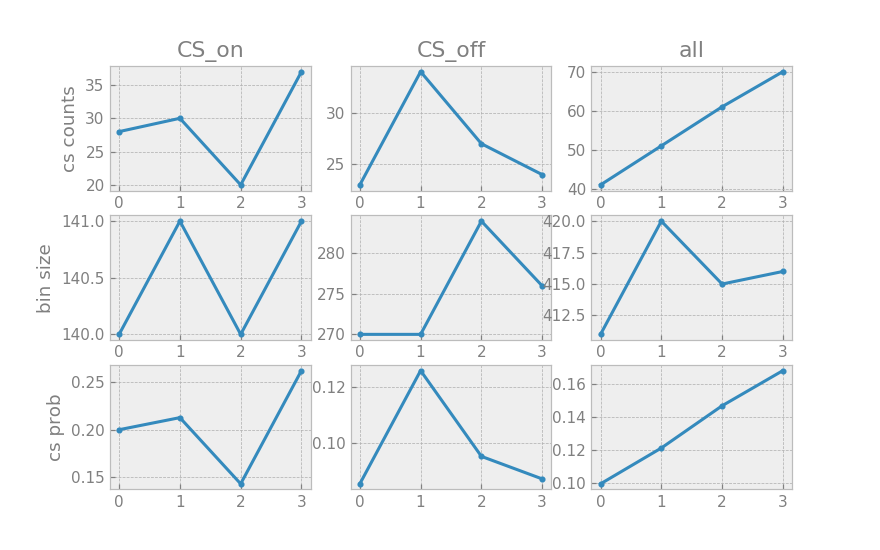

In [21]:

plt.figure(figsize=(8,5))

plt.subplot(331)
plt.plot(cs_counts_on, '.-')
plt.ylabel('cs counts')
plt.title('CS_on')

plt.subplot(334)
plt.plot(bin_sizes_on, '.-')
plt.ylabel('bin size')

plt.subplot(337)
plt.plot(cs_probs_on, '.-')
plt.ylabel('cs prob')



plt.subplot(332)
plt.plot(cs_counts_off, '.-')
plt.title('CS_off')

plt.subplot(335)
plt.plot(bin_sizes_off, '.-')

plt.subplot(338)
plt.plot(cs_probs_off, '.-')



plt.subplot(333)
plt.plot(cs_counts, '.-')
plt.title('all')

plt.subplot(336)
plt.plot(bin_sizes, '.-')

plt.subplot(339)
plt.plot(cs_probs, '.-')




In [22]:
hs_cs_on, bins_cs_on = np.histogram(rt_non_iss_cs_on, bins = np.arange(0,0.6 , 0.01))
hs_cs_on = (hs_cs_on*1.0/np.sum(hs_cs_on))

hs_cs_off, bins_cs_off = np.histogram(rt_non_iss_cs_off, bins = np.arange(0,0.6 , 0.01))
hs_cs_off = (hs_cs_off*1.0/np.sum(hs_cs_off))

center_cs_on = (bins_cs_on[:-1] + bins_cs_on[1:]) / 2
center_cs_off = (bins_cs_off[:-1] + bins_cs_off[1:]) / 2

<IPython.core.display.Javascript object>


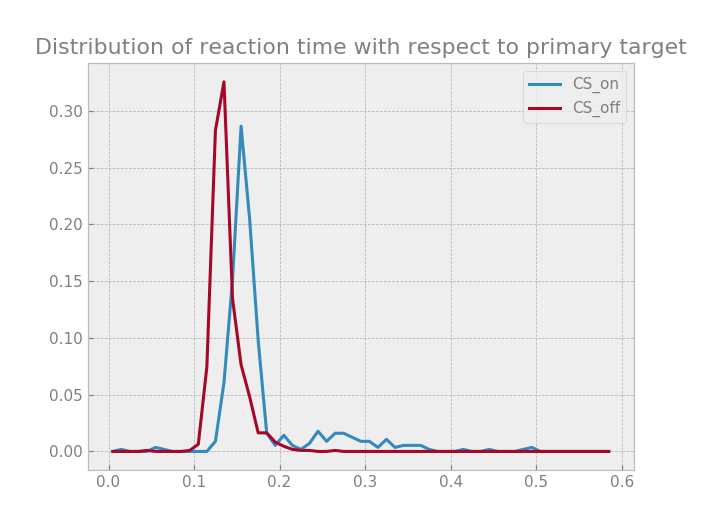

Text(0.5,1,u'Distribution of reaction time with respect to primary target')

In [23]:
plt.figure()
labels = ['CS_on', 'CS_off']
for i, rt in enumerate([rt_non_iss_cs_on, rt_non_iss_cs_off]):
    hs, bins = np.histogram(rt, bins = np.arange(0,0.6 , 0.01))
    hs = (hs*1.0/np.sum(hs))
    center = (bins[:-1] + bins[1:]) / 2
    plt.plot(center, hs, label=labels[i])
plt.legend()
plt.title('Distribution of reaction time with respect to primary target')

<IPython.core.display.Javascript object>


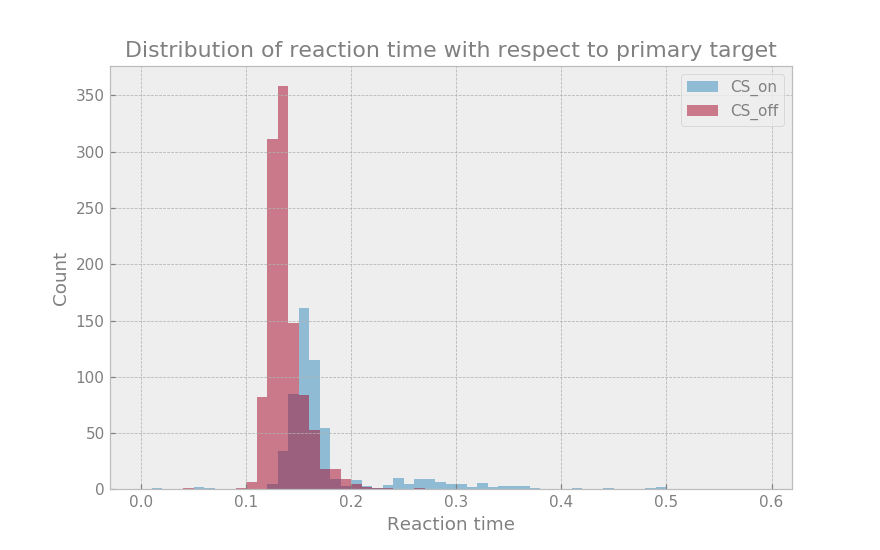

In [26]:

plt.figure(figsize=(8,5))
labels = ['CS_on', 'CS_off']
for i, rt in enumerate([rt_non_iss_cs_on, rt_non_iss_cs_off]):
    hs, bins = np.histogram(rt, bins = np.arange(0,0.6 , 0.01))
#     hs = (hs*1.0/np.sum(hs))
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hs, width=0.01, alpha = 0.5, label=labels[i])
plt.legend()
plt.title('Distribution of reaction time with respect to primary target')
plt.xlabel('Reaction time')
plt.ylabel('Count')
plt.savefig('../data/plots/cs-on-off-rxn-distro/cs_on_cs_off_'+f_name+'.png')

<IPython.core.display.Javascript object>


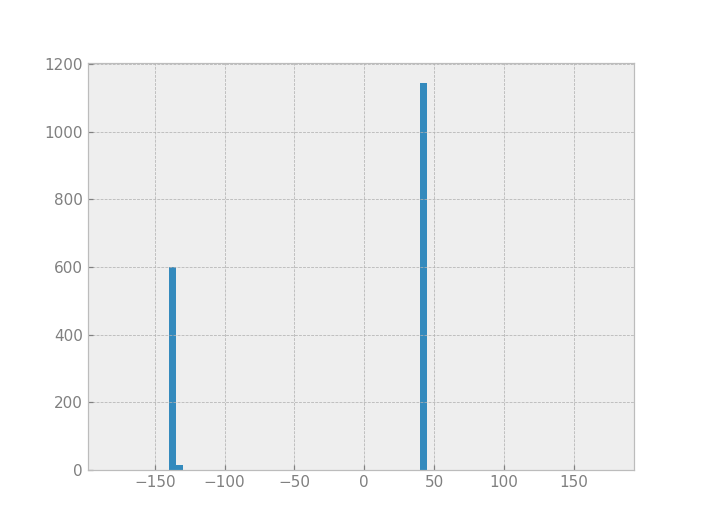

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  600.,
          16.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 1145.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([-180, -175, -170, -165, -160, -155, -150, -145, -140, -135, -130,
        -125, -120, -115, -110, -105, -100,  -95,  -90,  -85,  -80,  -75,
         -70,  -65,  -60,  -55,  -50,  -45,  -40,  -35,  -30,  -25,  -20,
         -15,  -10,   -5,    0,    5,   10,   15,   20,   25,   30,   35,
          40,   45,   50,   55,   60,   65,   70,   75,   80,   85,   90,
          95,  100,  105,  110,  115,  120,  125,  130,  135,  140,

In [25]:
plt.figure()
plt.hist(jump_dir[non_iss_target_jumps], bins=np.arange(-180,180,5))